In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
%cd Image Denoising

/content/drive/MyDrive/Image Denoising


In [ ]:
%cd PRIDnet

/content/drive/MyDrive/Image Denoising/PRIDnet


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [ ]:
def get_images_paths(root_dir):
    # Getting dataset images
    root = pathlib.Path(root_dir)
    img_paths = list(root.rglob("*.png*"))
    img_paths_lst = [str(path) for path in img_paths]

    gt_lst = []
    noisy_lst= []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('.')[0]
        if img_type=='199':
          continue
        noisy_lst.append(p)
    for o in img_paths_lst:
        img_type = o.split("/")[-1].split('.')[0]
        gt_lst.append(o)
    # print(gt_lst)
    gt_lst1 = []
    for i in gt_lst:
      img_type = i.split("/")[-1].split('.')[0]
      if img_type=='199':
        gt_lst1.append(i)

    gt_lst1 = (len(gt_lst)-1)*gt_lst1

    noisy_array = np.asarray(noisy_lst)
    gt_array = np.asarray(gt_lst1)
    return noisy_array, gt_array

In [ ]:
noisy_train_paths, gt_train_paths = get_images_paths("exp1/images/train")
noisy_test_paths, gt_test_paths = get_images_paths("exp1/images/test")

In [ ]:
print(noisy_train_paths.shape)
print(noisy_test_paths.shape)
print(gt_train_paths.shape)
print(gt_test_paths.shape)

(50,)
(12,)
(50,)
(12,)


In [ ]:
# Get gt_images in memory
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images_lst.append(img)
    return np.array(images_lst)

In [ ]:
noisy_train_images = get_images_in_mem(noisy_train_paths)
noisy_test_images = get_images_in_mem(noisy_test_paths)

gt_train_images = get_images_in_mem(gt_train_paths)
gt_test_images = get_images_in_mem(gt_test_paths)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

(50, 128, 128, 3)
(12, 128, 128, 3)
(50, 128, 128, 3)
(12, 128, 128, 3)


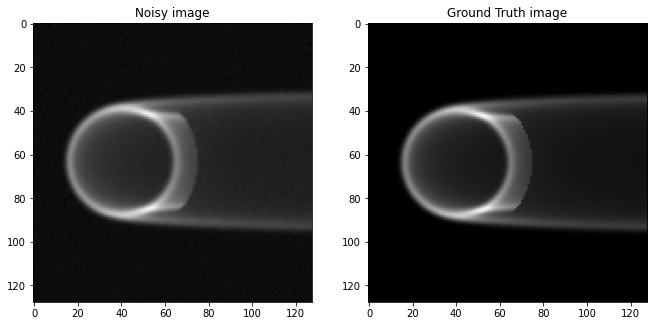

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(11,11))
axarr[0].imshow(noisy_train_images[30])
axarr[0].set_title("Noisy image")
axarr[1].imshow(gt_train_images[30])
axarr[1].title.set_text("Ground Truth image")

In [ ]:
def tf_data_generator(X, y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=4

image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

NameError: ignored

In [ ]:
image_generator_train

<PrefetchDataset element_spec=(TensorSpec(shape=(4, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(4, 128, 128, 3), dtype=tf.uint8, name=None))>

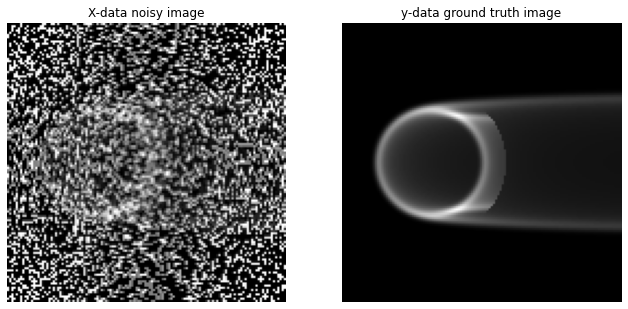

In [ ]:
# SANITY CHECK of the Dataset generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(11,11))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_4 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')

    def call(self, X):
        X_1 = self.conv_1(X)
        X_1 = Activation('relu')(X_1)

        X_2 = self.conv_2(X_1)
        X_2 = Activation('relu')(X_2)

        X_3 = self.conv_3(X_2)
        X_3 = Activation('relu')(X_3)

        X_4 = self.conv_4(X_3)
        X_4 = Activation('relu')(X_4)

        #print('---conv block=',X_4.shape)

        return X_4

In [ ]:
class Channel_attention(tf.keras.layers.Layer):
    def __init__(self, C=64, **kwargs):
        super().__init__(**kwargs)
        self.C=C
        self.gap = GlobalAveragePooling2D()
        self.dense_middle = Dense(units=2, activation='relu')
        self.dense_sigmoid = Dense(units=self.C, activation='sigmoid')

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        v = self.gap(X)
        #print("ca_ after gap =",v.shape)
        fc1 = self.dense_middle(v)
        #print("ca_ after fc1 =",fc1.shape)
        mu = self.dense_sigmoid(fc1)
        #print("ca_ after fc2 =",mu.shape)

        U_out = Multiply()([X, mu])

        #print('---channel attention block=',U_out.shape)

        return U_out

In [ ]:
class Avg_pool_Unet_Upsample_msfe(tf.keras.layers.Layer):
    def __init__(self, avg_pool_size, upsample_rate, **kwargs):
        super().__init__(**kwargs)
        # ---initialization for Avg pooling---
        self.avg_pool = AveragePooling2D(pool_size=avg_pool_size, padding='same')

        # --- initialization for Unet---
        self.deconv_lst = []
        filter=512
        for i in range(4):
            self.deconv_lst.append(Conv2DTranspose(filters=filter/2, kernel_size=[3, 3], strides=2, padding='same'))
            filter/=2

        self.conv_32_down_lst = []
        for i in range(4):
            self.conv_32_down_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_down_lst = []
        for i in range(4):
            self.conv_64_down_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_down_lst = []
        for i in range(4):
            self.conv_128_down_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_down_lst = []
        for i in range(4):
            self.conv_256_down_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_512_down_lst = []
        for i in range(4):
            self.conv_512_down_lst.append(Conv2D(filters=1024, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_32_up_lst = []
        for i in range(3):
            self.conv_32_up_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_up_lst = []
        for i in range(3):
            self.conv_64_up_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_up_lst = []
        for i in range(3):
            self.conv_128_up_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_up_lst = []
        for i in range(3):
            self.conv_256_up_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_3 = Conv2D(filters=3, kernel_size=[1, 1])

        self.pooling1_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling2_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling3_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling4_unet = MaxPool2D(pool_size=[2, 2], padding='same')

        # ---initialization for Upsampling---
        self.upsample = UpSampling2D(upsample_rate, interpolation='bilinear')

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'avg_pool_size': self.avg_pool_size,
          'upsample_rate':self.upsample_rate
        })
      return config

    def upsample_and_concat(self, x1, x2, i):
      deconv = self.deconv_lst[i](x1)
      deconv_output = Concatenate()([deconv, x2])
      return deconv_output

    def unet(self, input):
        # ---Unet downsampling---
        conv1 = input
        for c_32 in self.conv_32_down_lst:
            conv1 = c_32(conv1)
        pool1 = self.pooling1_unet(conv1)

        conv2 = pool1
        for c_64 in self.conv_64_down_lst:
            conv2 = c_64(conv2)
        pool2 = self.pooling2_unet(conv2)

        conv3 = pool2
        for c_128 in self.conv_128_down_lst:
            conv3 = c_128(conv3)
        pool3 = self.pooling3_unet(conv3)

        conv4 = pool3
        for c_256 in self.conv_256_down_lst:
            conv4 = c_256(conv4)
        pool4 = self.pooling4_unet(conv4)

        conv5 = pool4
        for c_512 in self.conv_512_down_lst:
            conv5 = c_512(conv5)

        # ---Unet upsampling---
        up6 = self.upsample_and_concat(conv5, conv4, 0)
        conv6 = up6
        for c_256 in self.conv_256_up_lst:
            conv6 = c_256(conv6)

        up7 = self.upsample_and_concat(conv6, conv3, 1)
        conv7 = up7
        for c_128 in self.conv_128_up_lst:
            conv7 = c_128(conv7)

        up8 = self.upsample_and_concat(conv7, conv2, 2)
        conv8 = up8
        for c_64 in self.conv_64_up_lst:
            conv8 = c_64(conv8)

        up9 = self.upsample_and_concat(conv8, conv1, 3)
        conv9 = up9
        for c_32 in self.conv_32_up_lst:
            conv9 = c_32(conv9)

        conv10 = self.conv_3(conv9)
        return conv10

    def call(self, X):
        avg_pool = self.avg_pool(X)
        #print("ap =",avg_pool.shape)
        unet = self.unet(avg_pool)
        upsample = self.upsample(unet)
        return upsample


In [ ]:
class Multi_scale_feature_extraction(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # self.msfe_16 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=16, upsample_rate=16)
        self.msfe_8 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=8, upsample_rate=8)
        self.msfe_4 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=4, upsample_rate=4)
        self.msfe_2 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=2, upsample_rate=2)
        self.msfe_1 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=1, upsample_rate=1)

    def call(self, X):
        # up_sample_16 = self.msfe_16(X)
        up_sample_8 = self.msfe_8(X)
        up_sample_4 = self.msfe_4(X)
        up_sample_2 = self.msfe_2(X)
        up_sample_1 = self.msfe_1(X)
        msfe_out = Concatenate()([X, up_sample_8, up_sample_4, up_sample_2, up_sample_1])

        #print('---Multi scale feature extraction block=',msfe_out.shape)
        return msfe_out

In [ ]:
class Kernel_selecting_module(tf.keras.layers.Layer):
    def __init__(self, C=21, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.c_3 = Conv2D(filters=self.C, kernel_size=(3,3), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_5 = Conv2D(filters=self.C, kernel_size=(5,5), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_7 = Conv2D(filters=self.C, kernel_size=(7,7), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.gap = GlobalAveragePooling2D()
        self.dense_two = Dense(units=2, activation='relu')
        self.dense_c1 = Dense(units=self.C)
        self.dense_c2 = Dense(units=self.C)
        self.dense_c3 = Dense(units=self.C)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        X_1 = self.c_3(X)
        X_2 = self.c_5(X)
        X_3 = self.c_7(X)

        X_dash = Add()([X_1, X_2, X_3])

        v_gap = self.gap(X_dash)
        v_gap = tf.reshape(v_gap, [-1, 1, 1, self.C])
        fc1 = self.dense_two(v_gap)

        alpha = self.dense_c1(fc1)
        beta = self.dense_c2(fc1)
        gamma = self.dense_c3(fc1)

        before_softmax = concatenate([alpha, beta, gamma], 1)
        # print(before_softmax.shape)
        after_softmax = softmax(before_softmax, axis=1)
        a1 = after_softmax[:, 0, :, :]
        # print(a1)
        a1 = tf.reshape(a1, [-1, 1, 1, self.C])
        # print(a1)
        a2 = after_softmax[:, 1, :, :]
        a2 = tf.reshape(a2, [-1, 1, 1, self.C])
        a3 = after_softmax[:, 2, :, :]
        a3 = tf.reshape(a3, [-1, 1, 1, self.C])

        select_1 = Multiply()([X_1, a1])
        select_2 = Multiply()([X_2, a2])
        select_3 = Multiply()([X_3, a3])

        out = Add()([select_1, select_2, select_3])

        return out

In [ ]:
def create_model():
    # ca_block = Channel Attention block
    # msfe_block = Multi scale feature extraction block
    # ksm = Kernel Selecting Module
    tf.keras.backend.clear_session()

    input = Input(shape=(128,128,3), name="input_layer")
    print("Input =",input.shape)

    conv_block = Convolutional_block()(input)
    print("Conv block =",conv_block.shape)
    ca_block = Channel_attention()(conv_block)
    print("Channel Attention =",ca_block.shape)
    ca_block = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ca_block)
    print("Channel Attention Last CNN =",ca_block.shape)
    ca_block = Concatenate()([input, ca_block])
    print("First phase =",ca_block.shape)
    print()

    msfe_block = Multi_scale_feature_extraction()(ca_block)

    print("Multi-scale feature extraction =",msfe_block.shape)

    ksm = Kernel_selecting_module()(msfe_block)
    ksm = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ksm)
    print("Kernel Selection Module =",ksm.shape)
    model = Model(inputs=[input], outputs=[ksm])
    return model

model = create_model()
model.summary()

Input = (None, 128, 128, 3)
Conv block = (None, 128, 128, 64)
Channel Attention = (None, 128, 128, 64)
Channel Attention Last CNN = (None, 128, 128, 3)
First phase = (None, 128, 128, 6)

Multi-scale feature extraction = (None, 128, 128, 18)
Kernel Selection Module = (None, 128, 128, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 convolutional_block (Convoluti  (None, 128, 128, 64  112576     ['input_layer[0][0]']            
 onal_block)                    )                                                                 
     

In [ ]:
# steps_per_epoch_train = len(noisy_train_images)
# steps_per_epoch_validation = len(noisy_test_images)

In [ ]:
# best_models_path = "./"
# callbacks_lst = [
#                  tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"PRIDNet_exp1_100epochs.h5", period=10, save_weights_only=False),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
# ]

In [ ]:
# model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
# model.fit(image_generator_train,
#           validation_data=image_generator_test,
#                         steps_per_epoch=steps_per_epoch_train,
#                         validation_steps=steps_per_epoch_validation,
#                         epochs=100,
#                         verbose=1,
#                         callbacks=callbacks_lst)

Epoch 1/100
50/50 [==============================] - 54s 436ms/step - loss: 823.8242 - val_loss: 466.4228 - lr: 9.0000e-04
Epoch 2/100
50/50 [==============================] - 20s 395ms/step - loss: 298.8253 - val_loss: 220.6862 - lr: 9.0000e-04
Epoch 3/100
50/50 [==============================] - 20s 402ms/step - loss: 198.3651 - val_loss: 136.3860 - lr: 9.0000e-04
Epoch 4/100
50/50 [==============================] - 20s 407ms/step - loss: 108.3381 - val_loss: 108.6683 - lr: 9.0000e-04
Epoch 5/100
50/50 [==============================] - 21s 412ms/step - loss: 77.3601 - val_loss: 85.3237 - lr: 9.0000e-04
Epoch 6/100
50/50 [==============================] - 20s 409ms/step - loss: 65.5470 - val_loss: 80.9623 - lr: 9.0000e-04
Epoch 7/100
50/50 [==============================] - 20s 407ms/step - loss: 73.2361 - val_loss: 96.5293 - lr: 9.0000e-04
Epoch 8/100
50/50 [==============================] - 20s 407ms/step - loss: 51.9023 - val_loss: 60.8738 - lr: 9.0000e-04
Epoch 9/100
50/50 [=====

In [ ]:
# best_models_path = "./"
# model.save(best_models_path+"PRIDNet_exp1_100epochs.h5")

In [ ]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)

    return predicted_image[0]

In [ ]:
def inference_batch_images(model, noisy_images):
    predicted_image = model.predict(noisy_images)
    return predicted_image

In [ ]:
def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = inference_single_image(model, X_test[i])
        predicted_image/=255

        f, axarr = plt.subplots(1,3, figsize=(21,21))
        axarr[0].imshow(noisy_image)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(gt_image)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(predicted_image)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()

In [ ]:
best_models_path = "./"
model = tf.keras.models.load_model(best_models_path+'PRIDNet_exp1_100epochs.h5', custom_objects={'Convolutional_block': Convolutional_block,
                                                                                                        'Channel_attention':Channel_attention,
                                                                                                        'Avg_pool_Unet_Upsample_msfe':Avg_pool_Unet_Upsample_msfe,
                                                                                                        'Multi_scale_feature_extraction':Multi_scale_feature_extraction,
                                                                                                        'Kernel_selecting_module':Kernel_selecting_module})

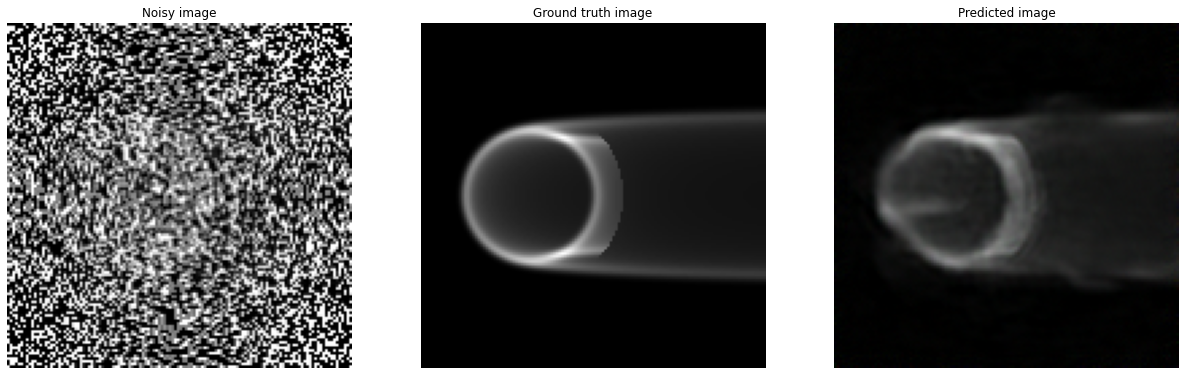

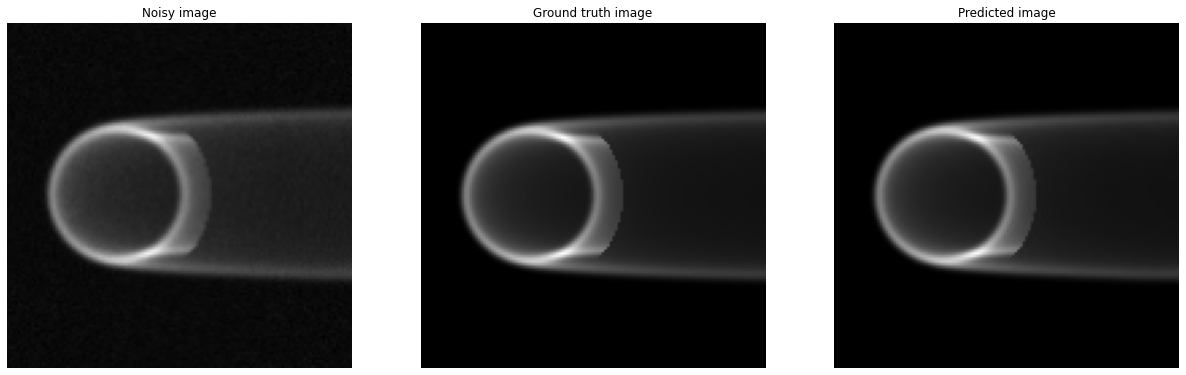

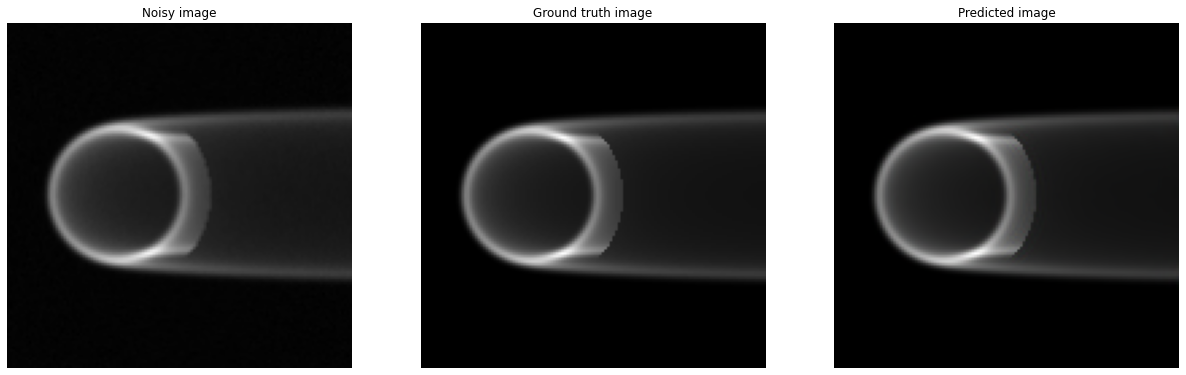

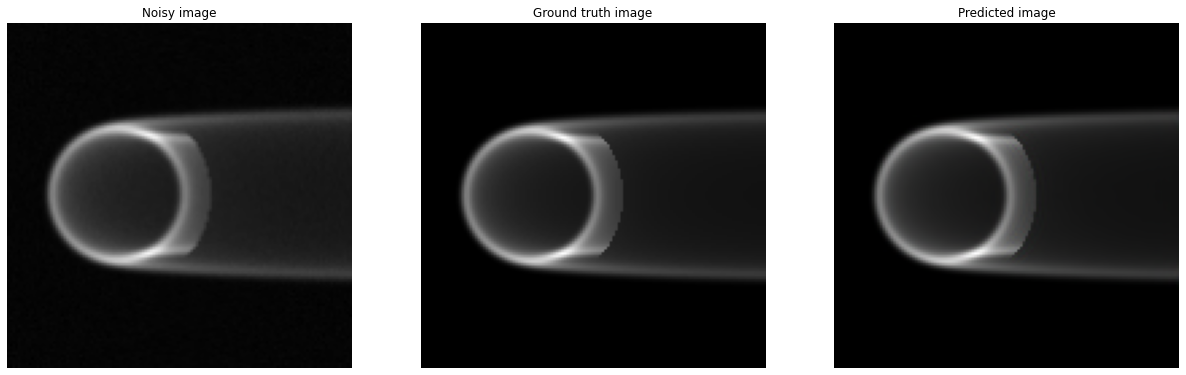

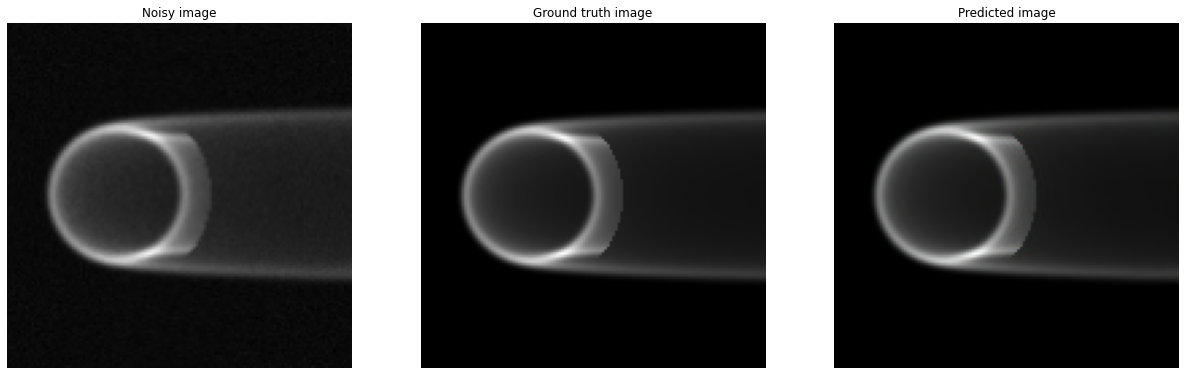

In [ ]:
visualize_predictions(model, noisy_test_images, gt_test_images, 5)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 22.40039628154723
Predicted average gt-predicted PSNR -> 46.22195529649964


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.3956737301791891
Predicted average gt-predicted SSIM -> 0.9565887095151034


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 15.343191705424633
Predicted average gt-predicted PSNR -> 42.361519084396946
Original average gt-noisy SSIM -> 0.18388197985311727
Predicted average gt-predicted SSIM -> 0.9841625395028272


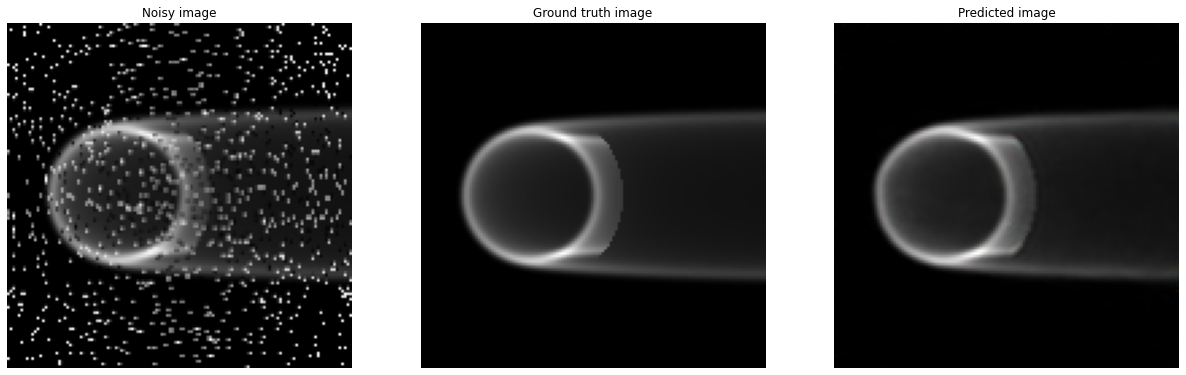

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../s10")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 12.826926584045893
Predicted average gt-predicted PSNR -> 39.95101080366011
Original average gt-noisy SSIM -> 0.1031111614128446
Predicted average gt-predicted SSIM -> 0.9833640677149428


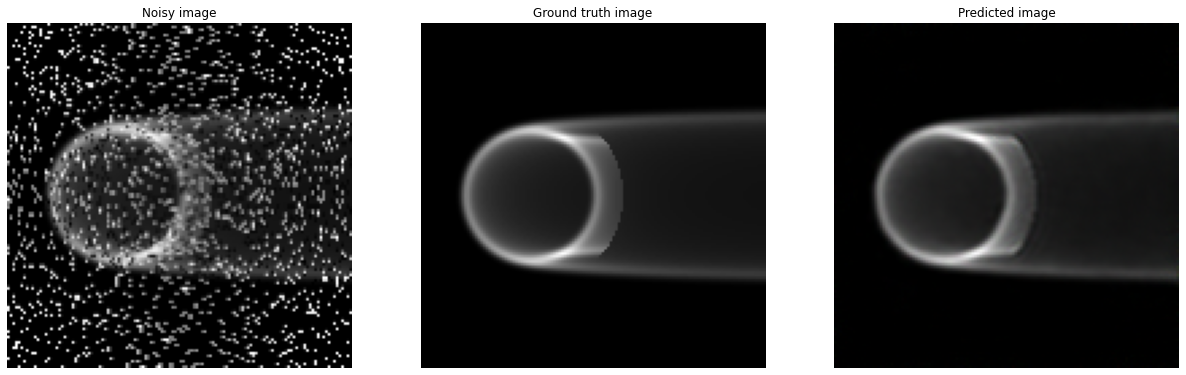

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../s20")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 10.721734094321022
Predicted average gt-predicted PSNR -> 39.65042995861239
Original average gt-noisy SSIM -> 0.07440870057297067
Predicted average gt-predicted SSIM -> 0.9766605081600842


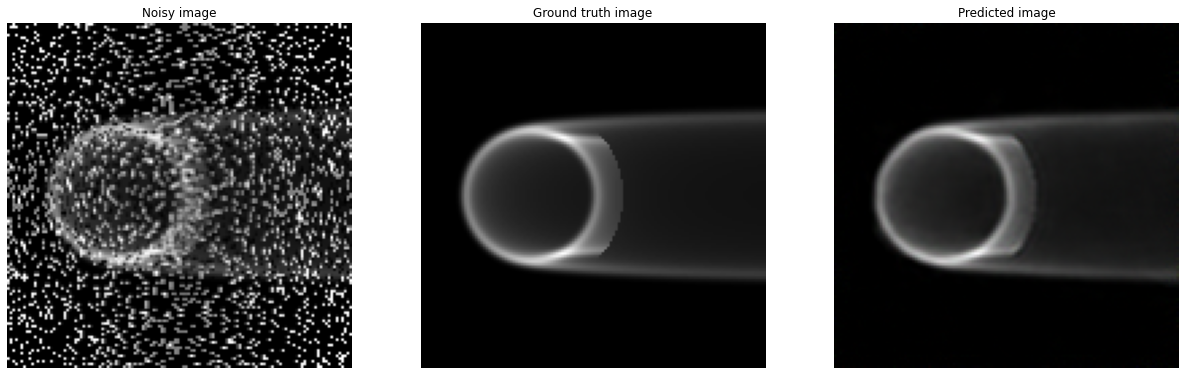

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../s30")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 9.50256504536793
Predicted average gt-predicted PSNR -> 37.963130730531475
Original average gt-noisy SSIM -> 0.05138084032866618
Predicted average gt-predicted SSIM -> 0.9677009462220098


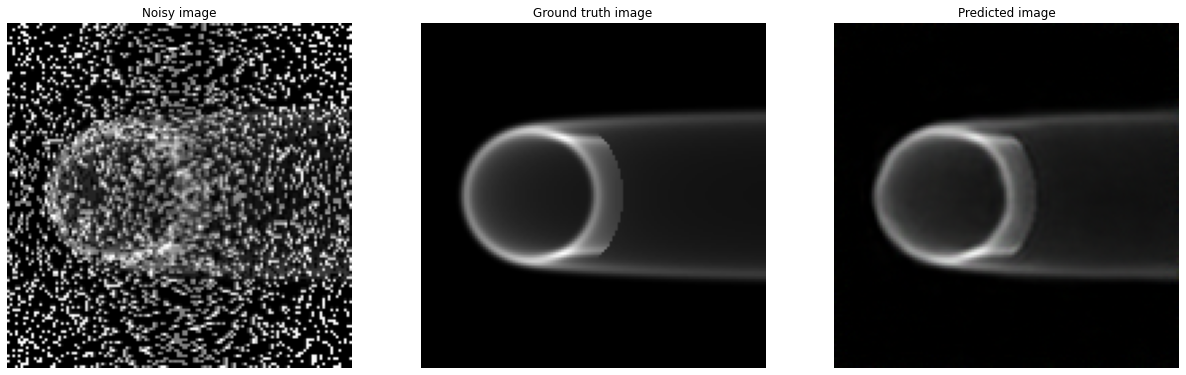

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../s40")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 8.056858116531686
Predicted average gt-predicted PSNR -> 33.20203444055595
Original average gt-noisy SSIM -> 0.040401617502778486
Predicted average gt-predicted SSIM -> 0.9545906429180308


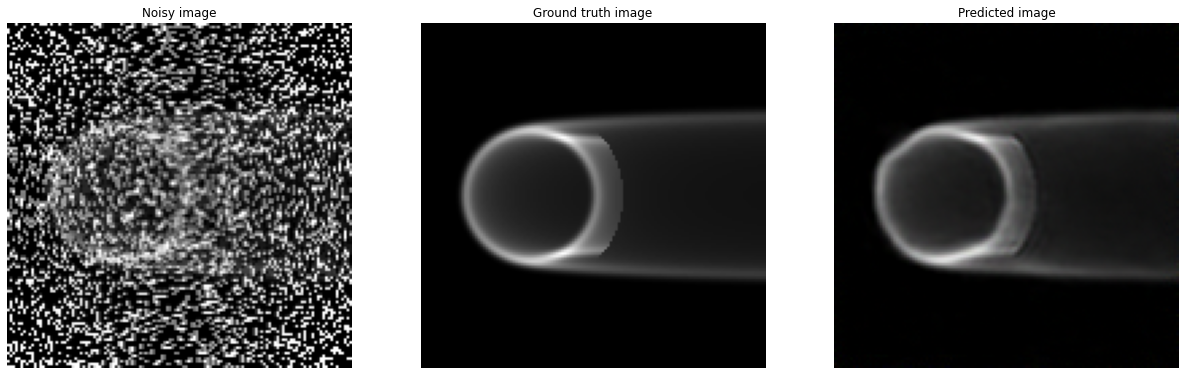

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../s50")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 7.292692775641023
Predicted average gt-predicted PSNR -> 29.273399149984204
Original average gt-noisy SSIM -> 0.031088620316039404
Predicted average gt-predicted SSIM -> 0.9360288340237104


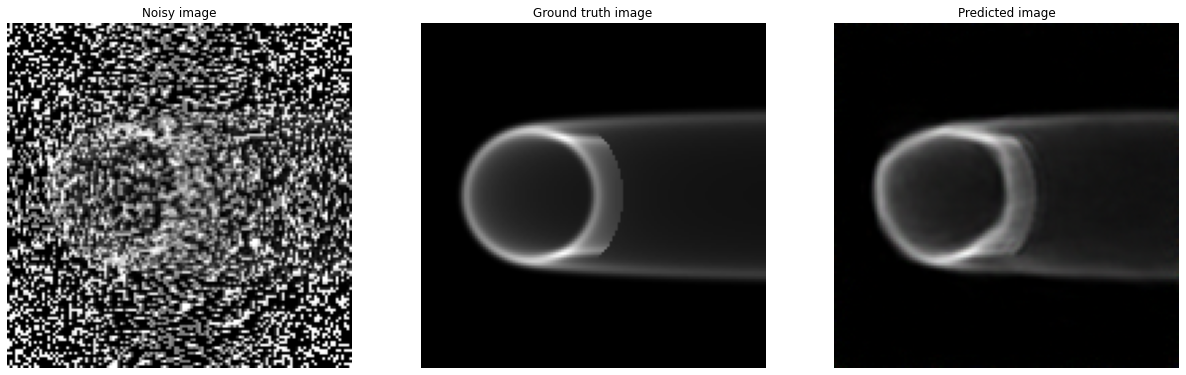

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../s60")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 6.610032128617181
Predicted average gt-predicted PSNR -> 29.27566756446167
Original average gt-noisy SSIM -> 0.020360506280832563
Predicted average gt-predicted SSIM -> 0.8683249616372004


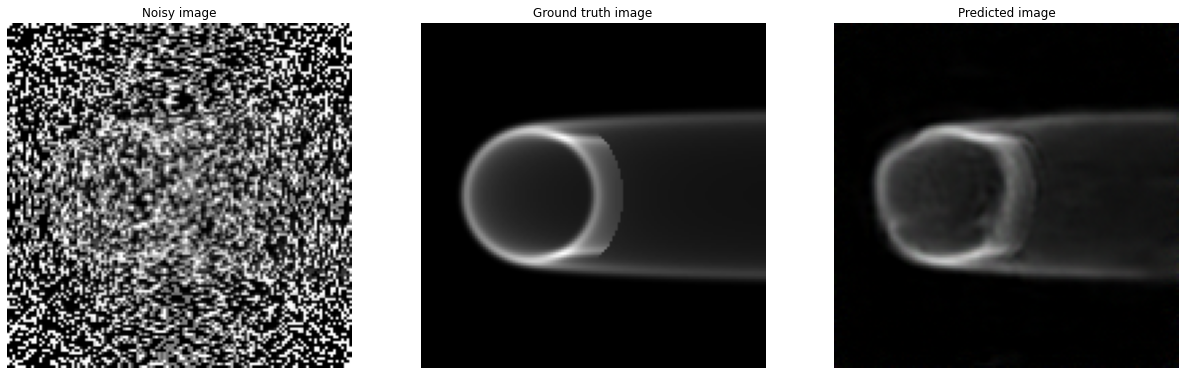

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../s70")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 6.172902224570605
Predicted average gt-predicted PSNR -> 23.9886336186305
Original average gt-noisy SSIM -> 0.013540809663124398
Predicted average gt-predicted SSIM -> 0.5411647946411144


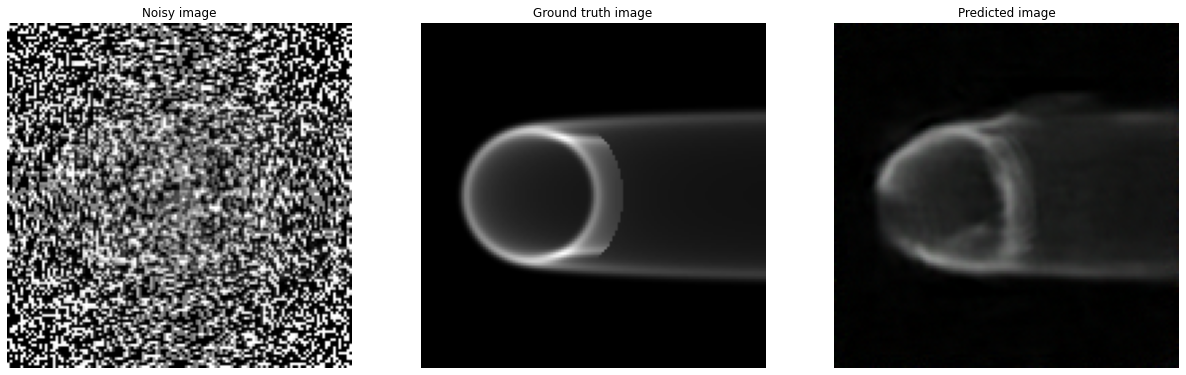

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../s80")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 32.645023211992765
Predicted average gt-predicted PSNR -> 53.449225461812695
Original average gt-noisy SSIM -> 0.9005081142956931
Predicted average gt-predicted SSIM -> 0.9982954610832128


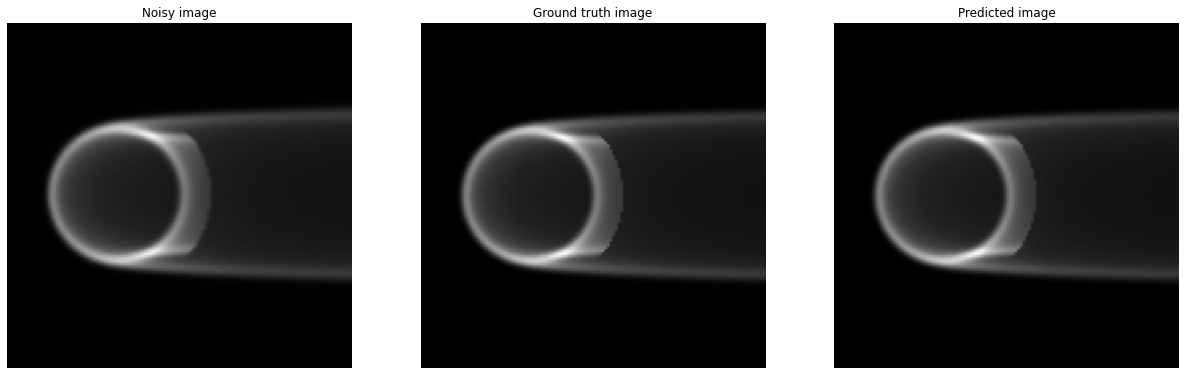

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g10")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 31.992104203085635
Predicted average gt-predicted PSNR -> 53.071539323951995
Original average gt-noisy SSIM -> 0.7176870617721635
Predicted average gt-predicted SSIM -> 0.9985675030257387


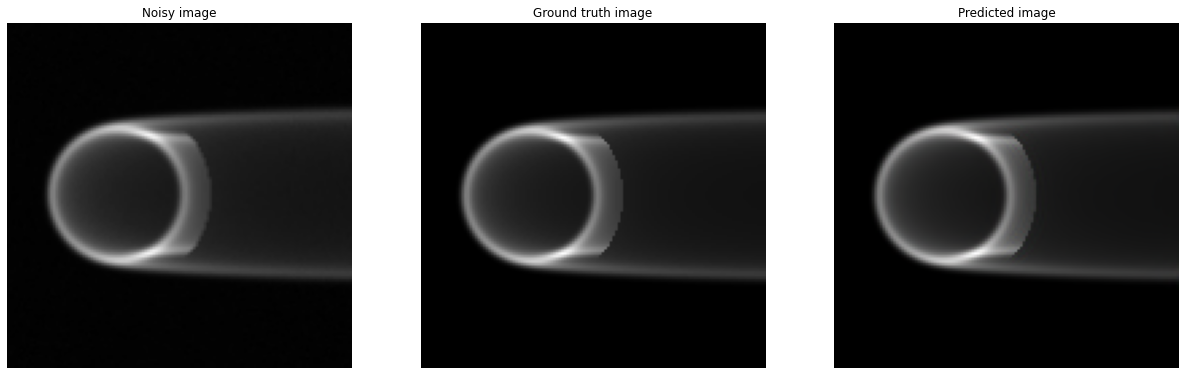

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g20")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 31.049839972771302
Predicted average gt-predicted PSNR -> 53.213549174846676
Original average gt-noisy SSIM -> 0.5896912298909927
Predicted average gt-predicted SSIM -> 0.9984666937568969


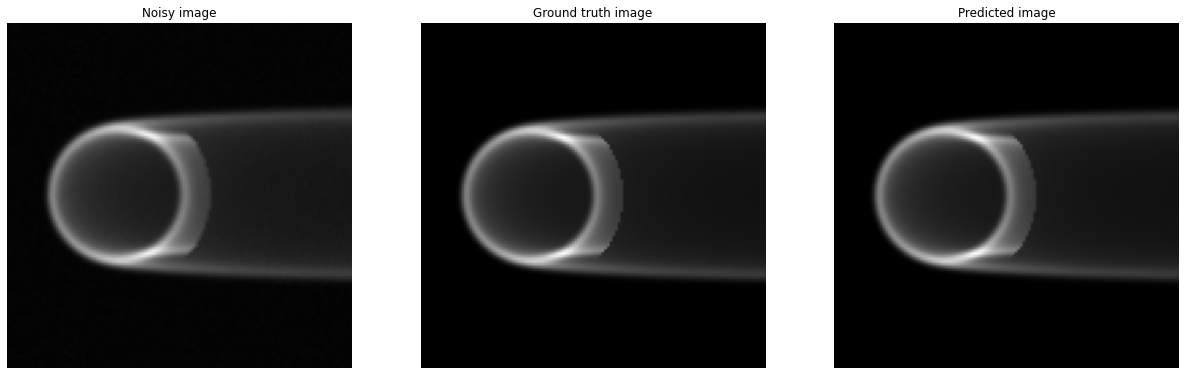

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g30")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 30.348054276838084
Predicted average gt-predicted PSNR -> 52.18185850154724
Original average gt-noisy SSIM -> 0.5498693663934593
Predicted average gt-predicted SSIM -> 0.9982900801542458


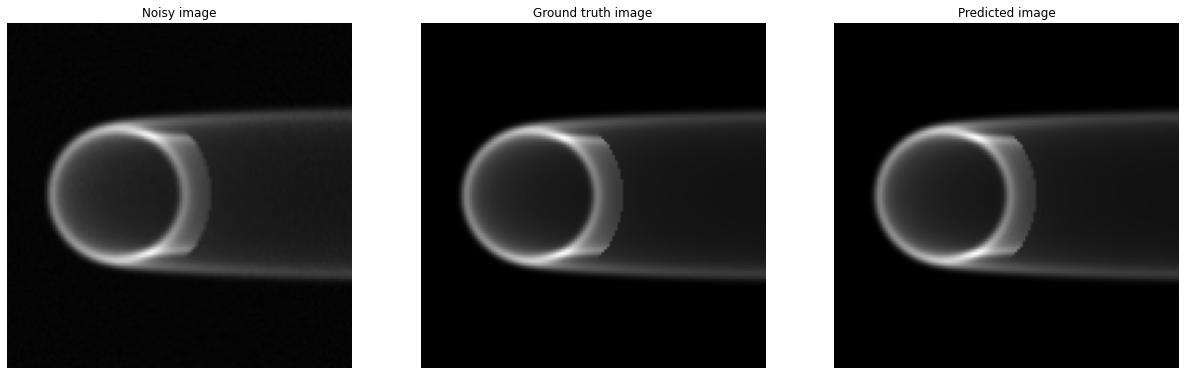

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g40")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 29.837137606252888
Predicted average gt-predicted PSNR -> 53.08858202745695
Original average gt-noisy SSIM -> 0.5215898614612334
Predicted average gt-predicted SSIM -> 0.9978087313522995


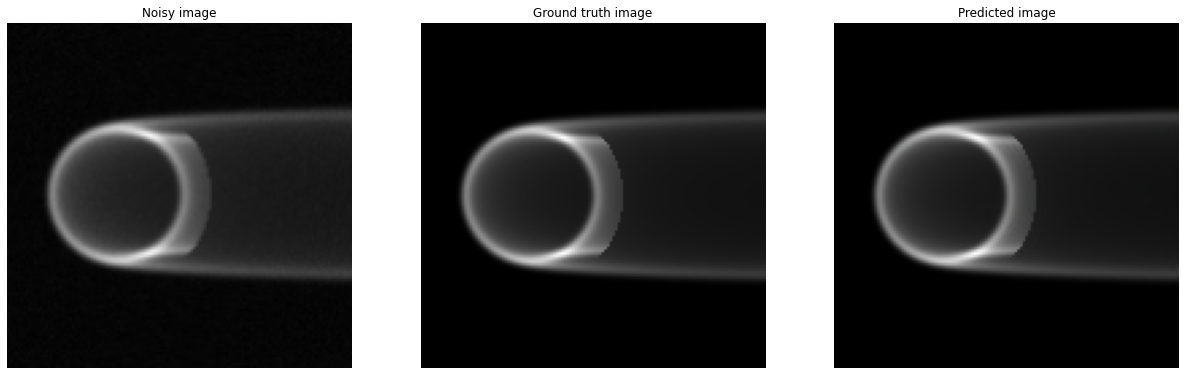

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g50")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 28.450140321394425
Predicted average gt-predicted PSNR -> 51.188998479842695
Original average gt-noisy SSIM -> 0.48455871975101233
Predicted average gt-predicted SSIM -> 0.9973035818905149


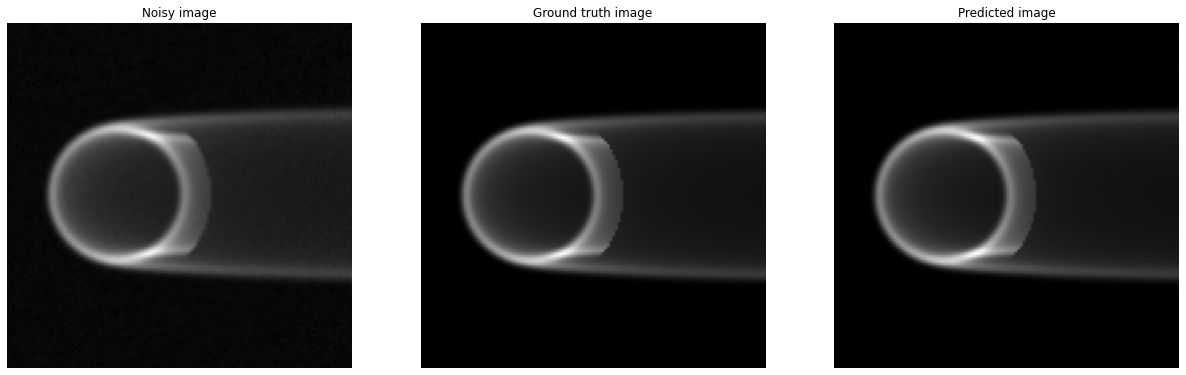

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g60")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 26.891310726576613
Predicted average gt-predicted PSNR -> 52.76432965546503
Original average gt-noisy SSIM -> 0.45496089628848285
Predicted average gt-predicted SSIM -> 0.9968766966243917


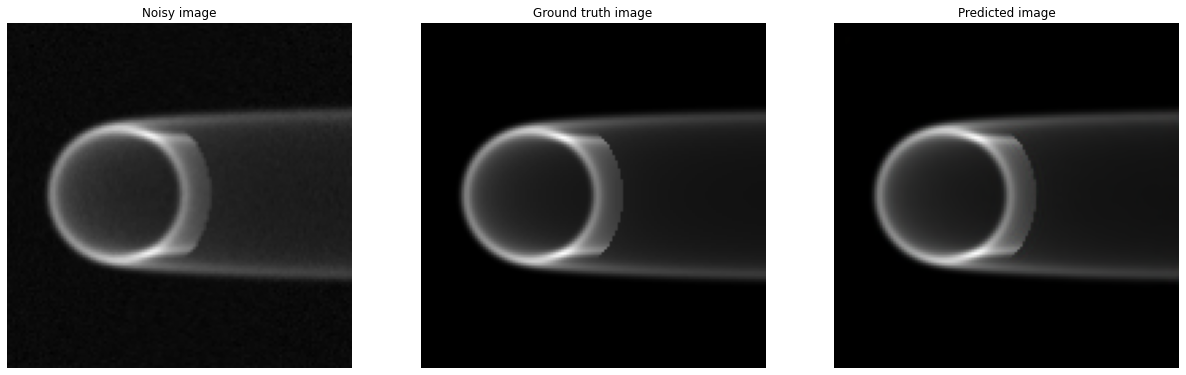

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g70")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 26.70169885773857
Predicted average gt-predicted PSNR -> 51.94299878569734
Original average gt-noisy SSIM -> 0.4484739101958553
Predicted average gt-predicted SSIM -> 0.9961314222999474


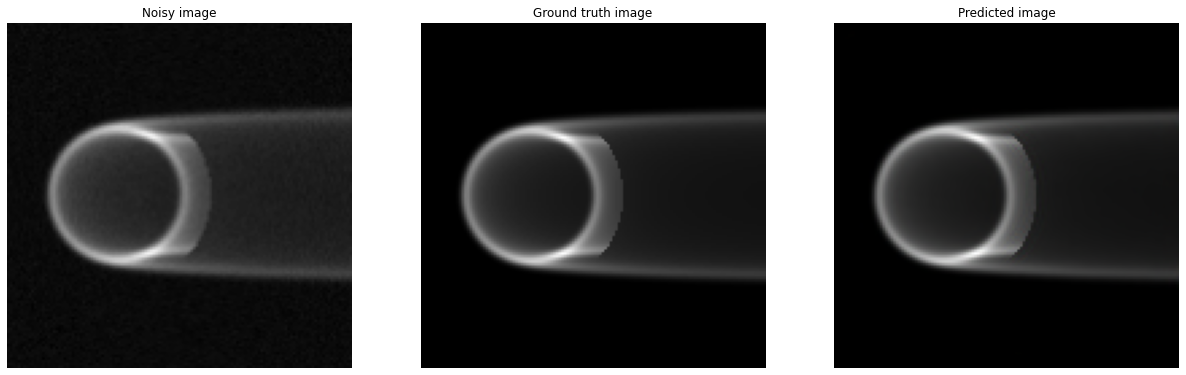

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g80")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 32.480120353005105
Predicted average gt-predicted PSNR -> 53.166176260722125
Original average gt-noisy SSIM -> 0.8532651415552023
Predicted average gt-predicted SSIM -> 0.9985687197650233


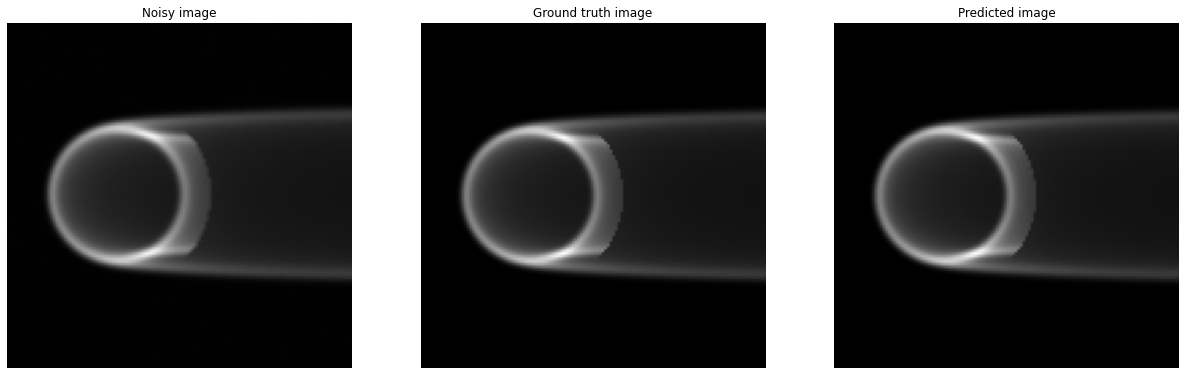

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../p10")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 31.54574638181726
Predicted average gt-predicted PSNR -> 53.53272479005585
Original average gt-noisy SSIM -> 0.6402435703597179
Predicted average gt-predicted SSIM -> 0.9986505959732508


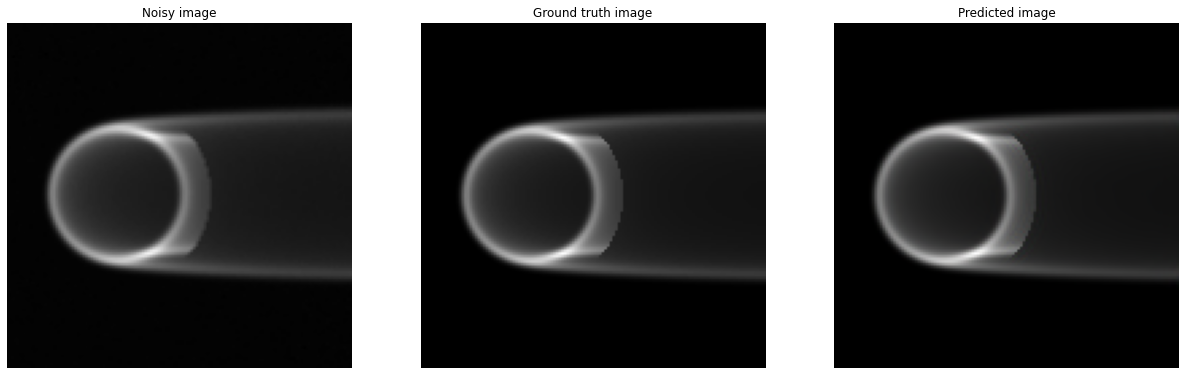

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../p20")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 30.277114185877853
Predicted average gt-predicted PSNR -> 52.84914189133896
Original average gt-noisy SSIM -> 0.5447035097690273
Predicted average gt-predicted SSIM -> 0.9986057392103037


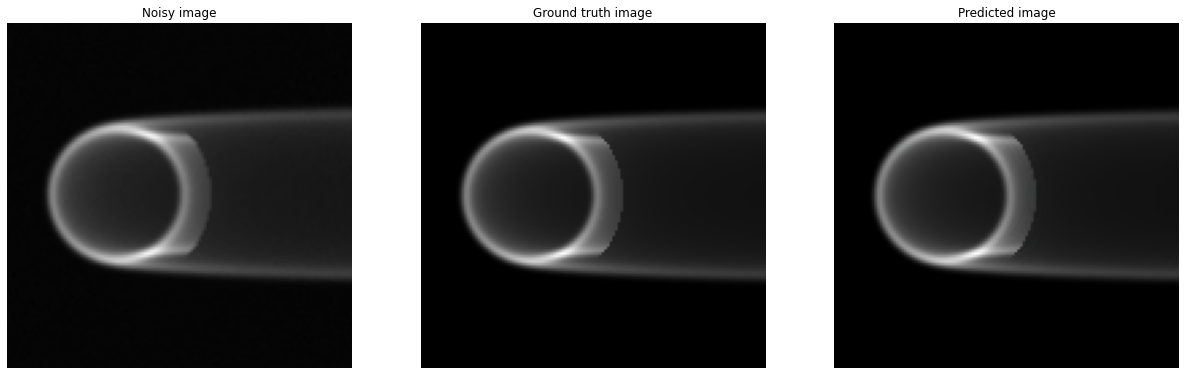

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../p30")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 28.915545457462656
Predicted average gt-predicted PSNR -> 52.60589076557655
Original average gt-noisy SSIM -> 0.4984781119879527
Predicted average gt-predicted SSIM -> 0.9982313928722307


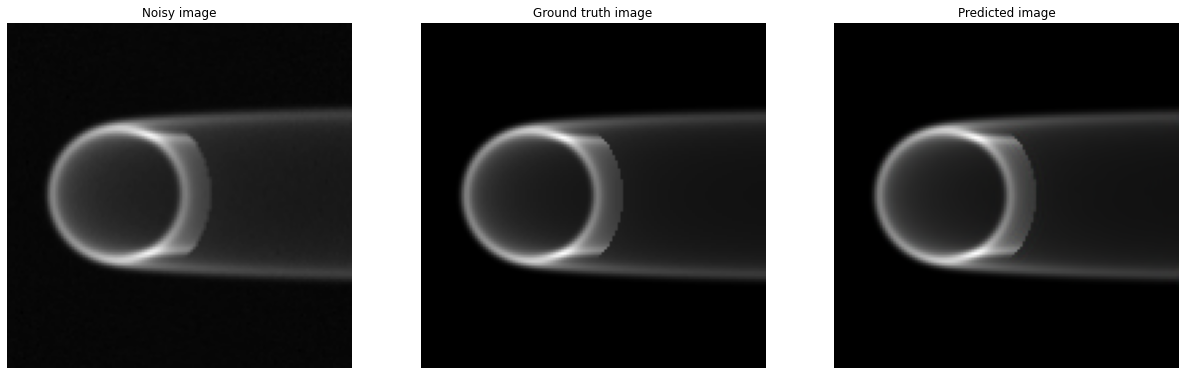

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../p40")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)
Original average gt-noisy PSNR -> 28.439412130223197
Predicted average gt-predicted PSNR -> 52.41976013480454
Original average gt-noisy SSIM -> 0.48524762044662434
Predicted average gt-predicted SSIM -> 0.9981951191510472


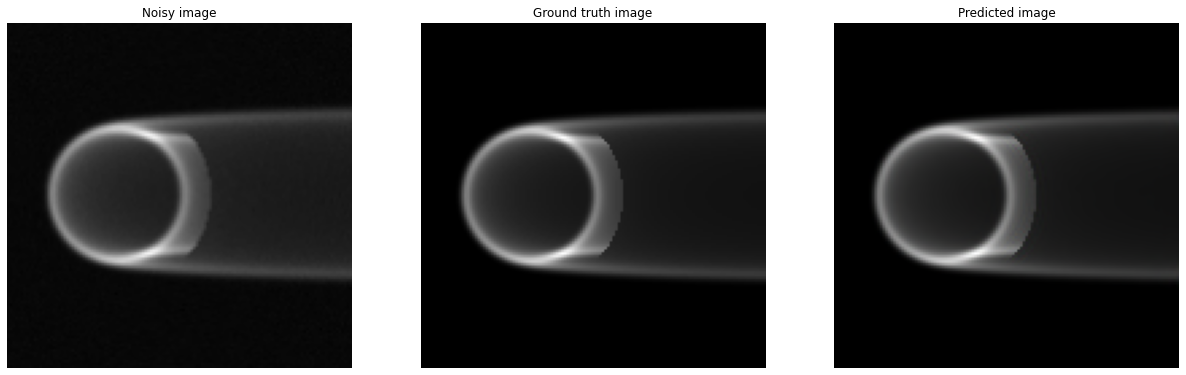

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../p50")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 26.506632092944034
Predicted average gt-predicted PSNR -> 52.40319297382218
Original average gt-noisy SSIM -> 0.4539462278128801
Predicted average gt-predicted SSIM -> 0.9980140184079885


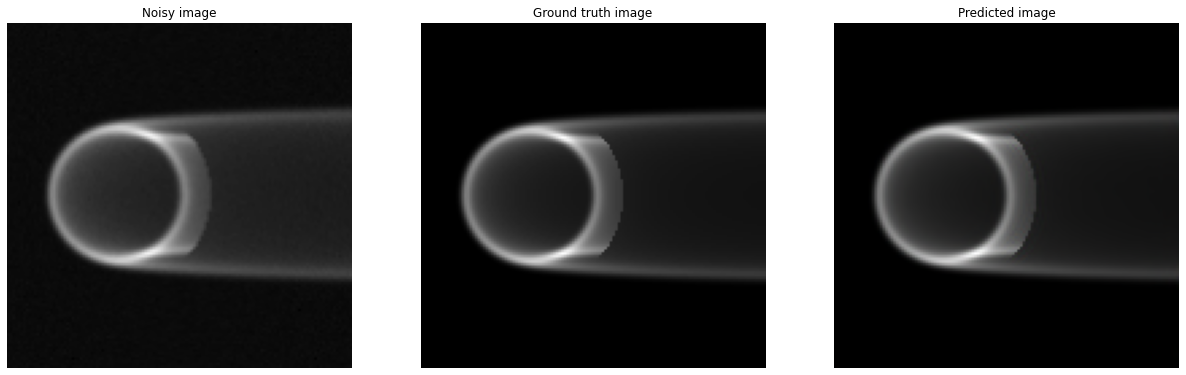

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../p60")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 25.467015639063998
Predicted average gt-predicted PSNR -> 52.030908374093165
Original average gt-noisy SSIM -> 0.44127795049965973
Predicted average gt-predicted SSIM -> 0.9973929061289861


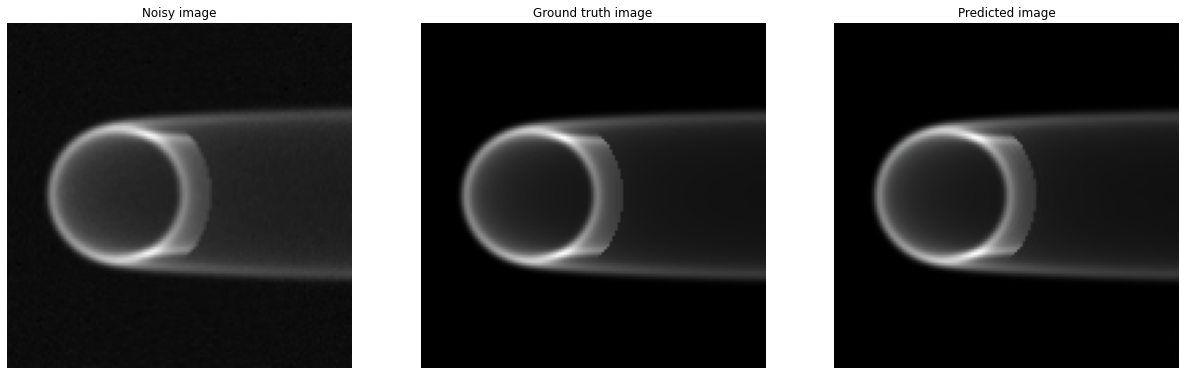

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../p70")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 128, 128, 3)
(1, 128, 128, 3)


Original average gt-noisy PSNR -> 25.971434963281382
Predicted average gt-predicted PSNR -> 52.215247673019405
Original average gt-noisy SSIM -> 0.4439433145477223
Predicted average gt-predicted SSIM -> 0.9969246638929988


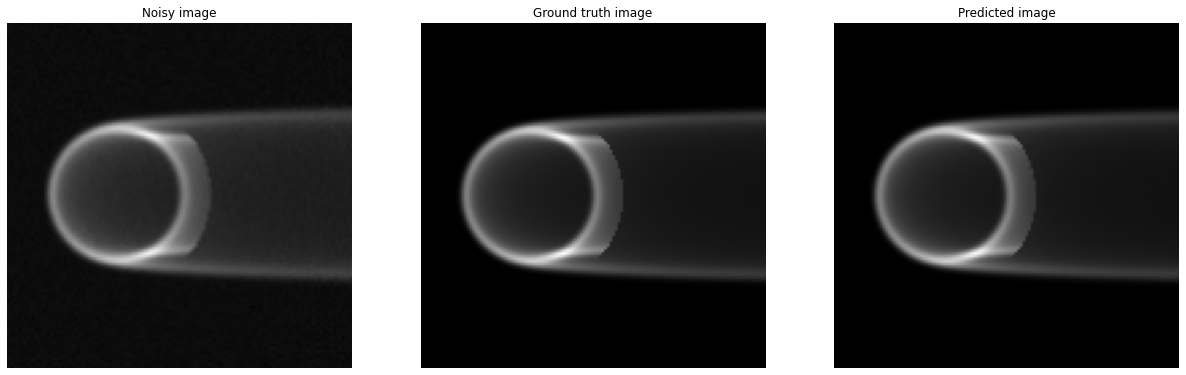

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../p80")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 128, 128, 3)
(10, 128, 128, 3)


Original average gt-noisy PSNR -> 9.674182537635847
Predicted average gt-predicted PSNR -> 34.89557581719741
Original average gt-noisy SSIM -> 0.056249674066661225
Predicted average gt-predicted SSIM -> 0.9072176989858557


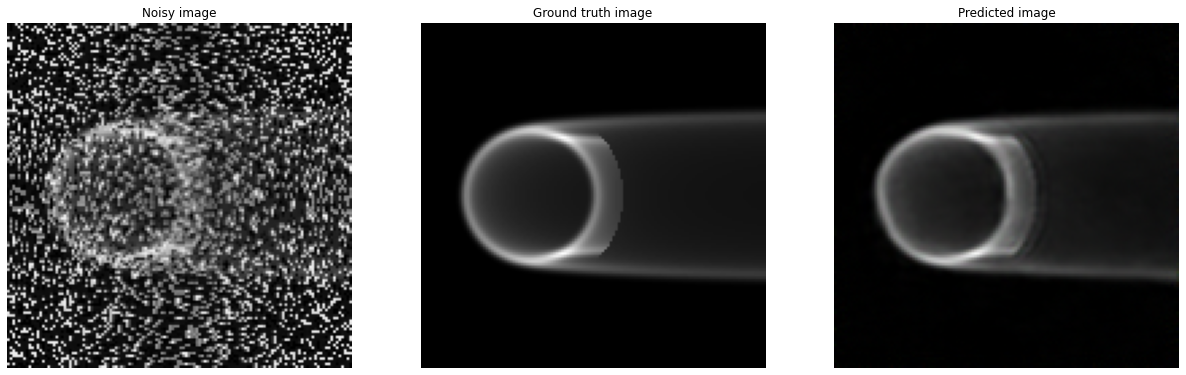

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g40_p40_s40")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 128, 128, 3)
(10, 128, 128, 3)


Original average gt-noisy PSNR -> 30.252170859925645
Predicted average gt-predicted PSNR -> 52.621238011526636
Original average gt-noisy SSIM -> 0.54507345496411
Predicted average gt-predicted SSIM -> 0.9982570562580143


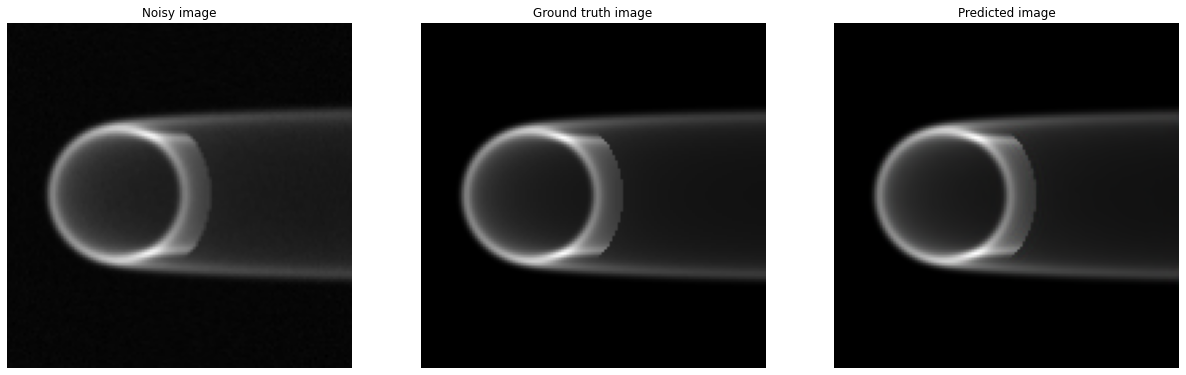

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../g40")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 128, 128, 3)
(10, 128, 128, 3)
Original average gt-noisy PSNR -> 29.16757517337636
Predicted average gt-predicted PSNR -> 52.498050427211254
Original average gt-noisy SSIM -> 0.5048314502573271
Predicted average gt-predicted SSIM -> 0.9982435086575926


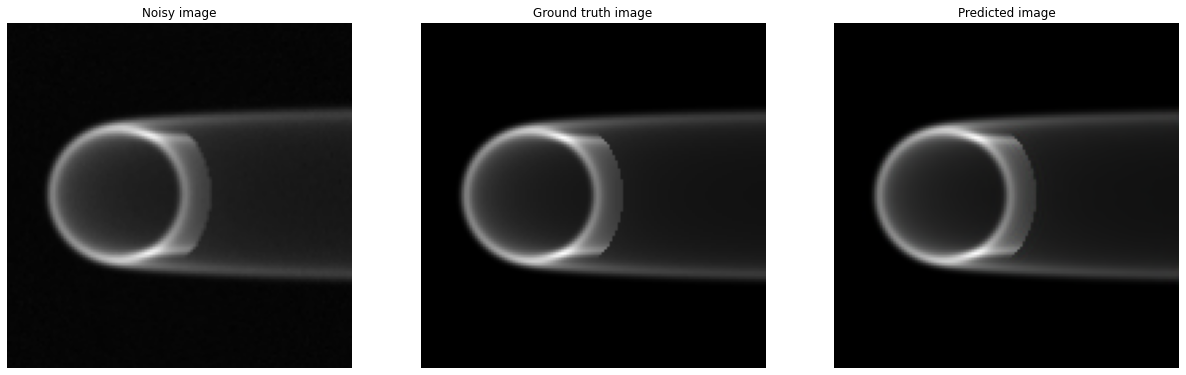

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../p40")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 128, 128, 3)
(10, 128, 128, 3)
Original average gt-noisy PSNR -> 9.400364353105171
Predicted average gt-predicted PSNR -> 38.65028404920812
Original average gt-noisy SSIM -> 0.05374584010741479
Predicted average gt-predicted SSIM -> 0.9715987877432779


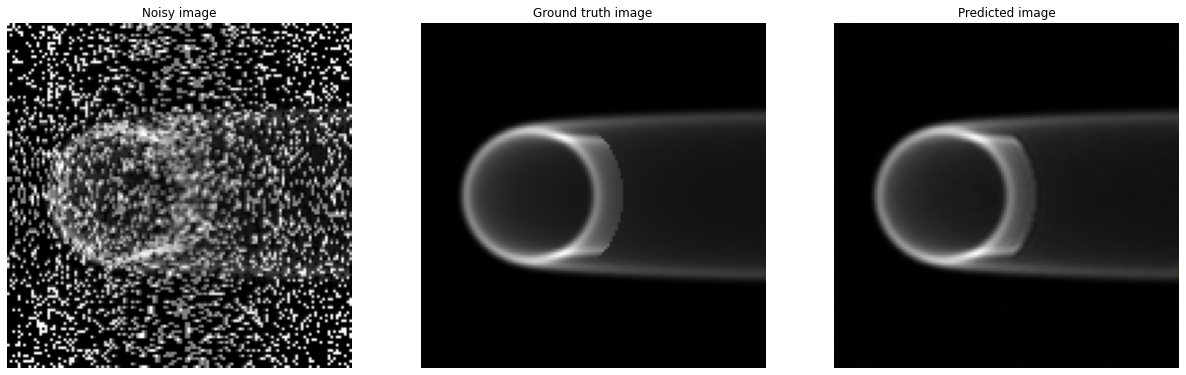

In [ ]:
noisy_test_paths1, gt_test_paths1 = get_images_paths("../s40")

noisy_test_images1 = get_images_in_mem(noisy_test_paths1)
gt_test_images1 = get_images_in_mem(gt_test_paths1)

print(noisy_test_images1.shape)
print(gt_test_images1.shape)

visualize_predictions(model, noisy_test_images1, gt_test_images1, 1)

from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images1)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images1.shape[0]
psnr_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images1)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images1, noisy_test_images1, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images1.shape[0]
ssim_prediction_mean/=gt_test_images1.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)


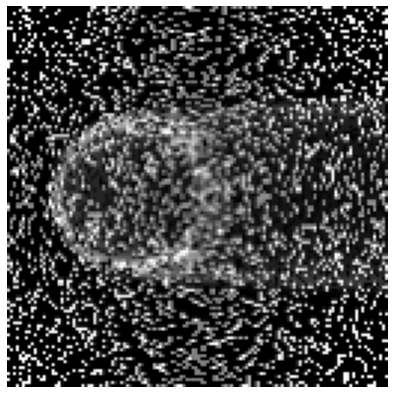

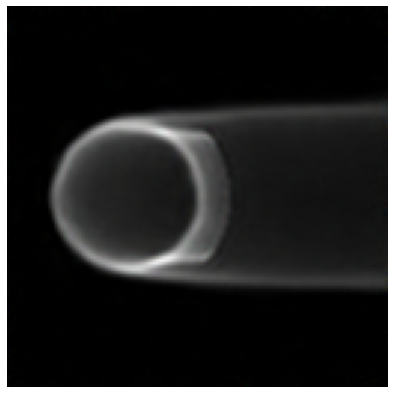

In [ ]:
img_path = "../s40/s40_8.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))

predicted_image = inference_single_image(model, img)
predicted_image/=255

f, axarr = plt.subplots(1,1, figsize=(7,7))
axarr.imshow(img)
axarr.set_axis_off()
plt.savefig('s40_noisy.png', bbox_inches='tight',pad_inches=0,dpi=100)

f, axarr1 = plt.subplots(1,1, figsize=(7,7))
axarr1.imshow(predicted_image)
axarr1.set_axis_off()
plt.savefig('s40_pred.png', bbox_inches='tight',pad_inches=0,dpi=100)

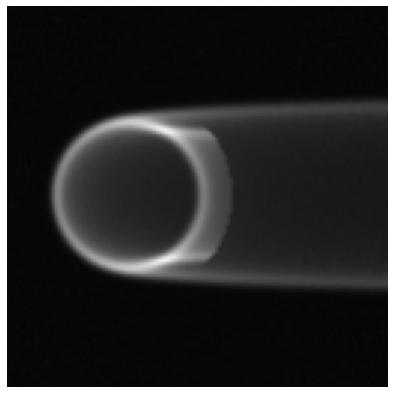

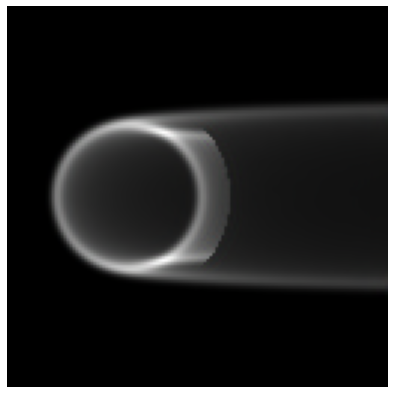

In [ ]:
img_path = "../p40/p40_8.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))

predicted_image = inference_single_image(model, img)
predicted_image/=255

f, axarr = plt.subplots(1,1, figsize=(7,7))
axarr.imshow(img)
axarr.set_axis_off()
plt.savefig('p40_noisy.png', bbox_inches='tight',pad_inches=0,dpi=100)

f, axarr1 = plt.subplots(1,1, figsize=(7,7))
axarr1.imshow(predicted_image)
axarr1.set_axis_off()
plt.savefig('p40_pred.png', bbox_inches='tight',pad_inches=0,dpi=100)

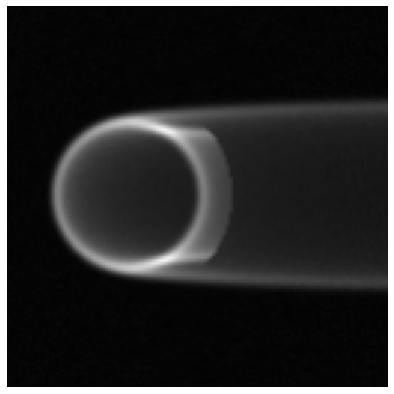

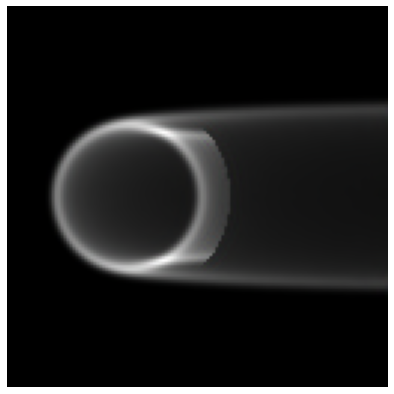

In [ ]:
img_path = "../g40/g40_8.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))

predicted_image = inference_single_image(model, img)
predicted_image/=255

f, axarr = plt.subplots(1,1, figsize=(7,7))
axarr.imshow(img)
axarr.set_axis_off()
plt.savefig('g40_noisy.png', bbox_inches='tight',pad_inches=0,dpi=100)

f, axarr1 = plt.subplots(1,1, figsize=(7,7))
axarr1.imshow(predicted_image)
axarr1.set_axis_off()
plt.savefig('g40_pred.png', bbox_inches='tight',pad_inches=0,dpi=100)